# *Note*

# *This notebook uses the limited price history currently available in the project folder. It needs to be updated once the full Bloomberg historical series is downloaded. Replace the existing Price sheet with the extended data and the calculations will update automatically.*

# 03 – Historical volatility vs implied volatility

In this notebook we compute the historical volatility of CAT using daily
closing prices and compare it to the at the money (ATM) implied volatility
from the option market.

Historical volatility is the realised variability of the underlying:

$$
r_t = \ln\left(\frac{S_t}{S_{t-1}}\right), \qquad
\sigma_{\text{hist}} = \sqrt{252}\,\text{std}(r_t)
$$

We use only data **up to the trade date**, so we do not look into the future
when estimating volatility. We then compare this historical estimate to the
ATM implied volatility from the option chain on the trade date.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get project root (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.data_loader import (
    load_price,
    load_calls,
    load_usgg1m,
    TRADE_DATE,
    EXPIRY_DATE,
)

In [2]:
# Load Bloomberg historical price data
price_df = load_price().copy()

# Ensure Date is datetime
price_df["Date"] = pd.to_datetime(price_df["Date"])

# Use only data up to and including the trade date
price_df = price_df[price_df["Date"] <= TRADE_DATE]

# Sort oldest to newest
price_df = price_df.sort_values("Date").reset_index(drop=True)

# Use PX_LAST as closing price
price_df["Close"] = price_df["PX_LAST"]

price_df.head(), price_df.tail()


(        Date  PX_LAST  PX_BID  PX_VOLUME  IVOL_MONEYNESS   Close
 0 2025-08-19   416.09  415.79    3543629         23.2654  416.09
 1 2025-08-20   420.59  420.46    4060195         23.2309  420.59
 2 2025-08-21   417.89  417.68    2504344         24.8082  417.89
 3 2025-08-22   435.67  435.47    3785096         24.0369  435.67
 4 2025-08-25   432.30  432.17    1858079         22.2296  432.30,
          Date  PX_LAST  PX_BID  PX_VOLUME  IVOL_MONEYNESS   Close
 18 2025-09-15   435.94  435.65    2255875         24.6183  435.94
 19 2025-09-16   440.67  440.55    2366493         26.8583  440.67
 20 2025-09-17   450.66  450.52    4512193         23.1695  450.66
 21 2025-09-18   466.96  467.22    4331863         25.0071  466.96
 22 2025-09-19   466.54  466.83    5069345         23.5027  466.54)

## Log returns

We compute **daily log returns**:

$$
r_t = \ln\left(\frac{S_t}{S_{t-1}}\right)
$$

In [3]:
# Compute daily log returns
price_df["log_ret"] = np.log(price_df["Close"] / price_df["Close"].shift(1))

# Drop first NaN
rets = price_df["log_ret"].dropna()

price_df[["Date", "Close", "log_ret"]].head()


,Date,Close,log_ret
0,2025-08-19,416.09,NaN
1,2025-08-20,420.59,0.010757
2,2025-08-21,417.89,-0.006440
3,2025-08-22,435.67,0.041667
4,2025-08-25,432.30,-0.007765


In [4]:
# Daily volatility (standard deviation of daily log returns)
daily_vol = rets.std()

# Annualised historical volatility using 252 trading days
hist_vol = daily_vol * np.sqrt(252)

daily_vol, hist_vol


(0.016432171892965766, np.float64(0.26085264197671737))

### Historical volatility estimate

The standard deviation of daily log returns gives a **daily** volatility
estimate. To put this on the same scale as implied volatility from options,
we annualise it by multiplying by $(\sqrt{252})$, the approximate number of
trading days in a year:

$$
\sigma_{\text{hist}} = \sqrt{252}\,\text{std}(r_t)
$$

This yields an annualised realised volatility of the CAT share price over the
pre trade window. The estimate is based only on data available at the trade
date, so we are not using future information.


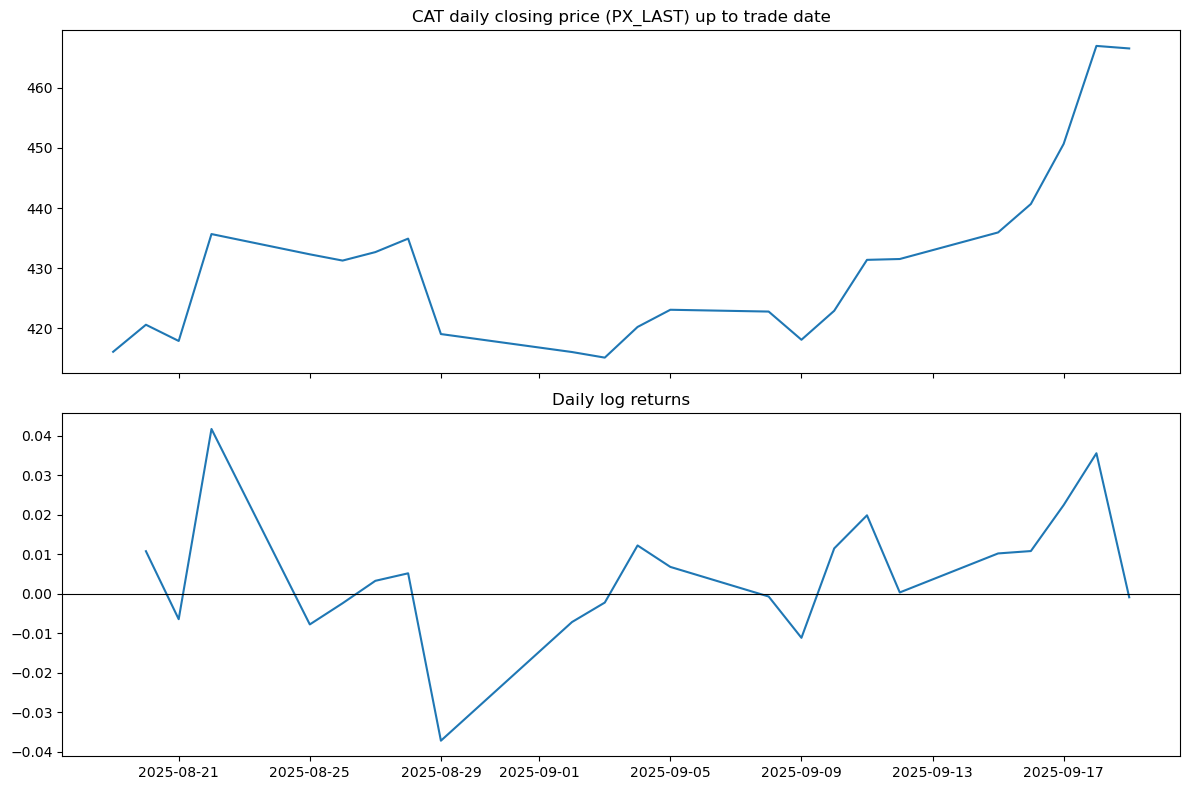

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(price_df["Date"], price_df["Close"])
ax[0].set_title("CAT daily closing price (PX_LAST) up to trade date")

ax[1].plot(price_df["Date"].iloc[1:], rets)
ax[1].set_title("Daily log returns")
ax[1].axhline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()


In [6]:
# Rolling 20 day realised volatility (annualised)
price_df["rolling_vol_20d"] = (
    price_df["log_ret"].rolling(20).std() * np.sqrt(252)
)

price_df[["Date", "rolling_vol_20d"]].tail()


,Date,rolling_vol_20d
18,2025-09-15,NaN
19,2025-09-16,NaN
20,2025-09-17,0.249247
21,2025-09-18,0.272586
22,2025-09-19,0.270139


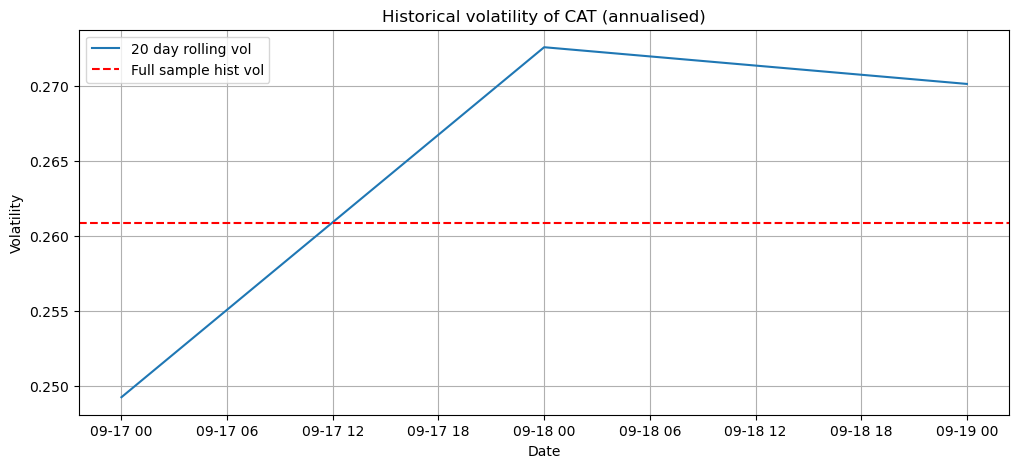

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(price_df["Date"], price_df["rolling_vol_20d"], label="20 day rolling vol")
plt.axhline(hist_vol, color="red", linestyle="--", label="Full sample hist vol")

plt.title("Historical volatility of CAT (annualised)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


## Comparison with ATM implied volatility

To compare realised and implied volatility, we compute:

- the historical volatility $(\sigma_{\text{hist}})$ from CAT daily returns
  over the pre trade window
- the Black Scholes implied volatility of the **ATM** call option on the
  trade date.

The implied volatility $(\sigma_{\text{impl}})$ is the value of $(\sigma)$
such that the Black Scholes call price equals the observed mid market call
price:

$$
C_{\text{BS}}(S_0, K, T, r, \sigma) = C_{\text{mid}}
$$

We focus on the strike $(K)$ closest to the spot price $(S_0)$.


In [8]:
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq

def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def implied_vol_call(price, S, K, T, r, sigma_low=1e-4, sigma_high=5.0):
    intrinsic = max(S - K * exp(-r * T), 0.0)
    if price <= intrinsic:
        return np.nan

    def f(sigma):
        return bs_call_price(S, K, T, r, sigma) - price

    try:
        return brentq(f, sigma_low, sigma_high, maxiter=100)
    except ValueError:
        return np.nan


In [9]:
from src.data_loader import load_calls, load_usgg1m

# Load option chain and rates
calls = load_calls().copy()
usgg = load_usgg1m().copy()

# Spot price S0 on trade date
S0 = price_df.loc[price_df["Date"] == TRADE_DATE, "Close"].iloc[0]

# Risk free rate: first rate on or after trade date
usgg["Date"] = pd.to_datetime(usgg["Date"])
r_row = usgg.loc[usgg["Date"] >= TRADE_DATE].iloc[0]
r = float(r_row["Rate"])

# Time to maturity in years
T_days = (EXPIRY_DATE - TRADE_DATE).days
T = T_days / 365.0

S0, r, T


(np.float64(466.54), 0.040304, 0.07671232876712329)

In [10]:
# Mid prices for calls
calls["Mid"] = 0.5 * (calls["Bid"] + calls["Ask"])

# Find strike closest to spot (ATM)
atm_idx = (calls["Strike"] - S0).abs().idxmin()
atm_row = calls.loc[atm_idx]

K_atm = atm_row["Strike"]
C_mid_atm = atm_row["Mid"]

iv_atm = implied_vol_call(C_mid_atm, S0, K_atm, T, r)

K_atm, C_mid_atm, iv_atm


(np.int64(470), np.float64(11.9750003814697), 0.25081395260091466)

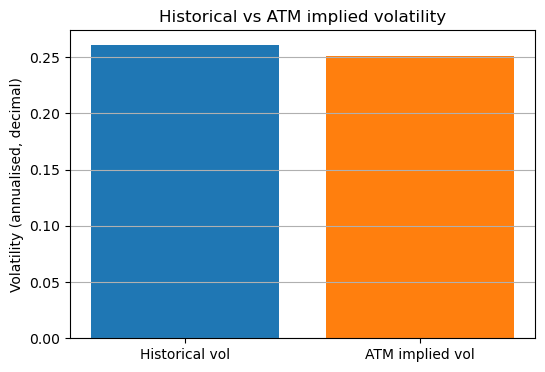

(np.float64(0.26085264197671737), 0.25081395260091466)

In [11]:
labels = ["Historical vol", "ATM implied vol"]
values = [hist_vol, iv_atm]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["tab:blue", "tab:orange"])
plt.ylabel("Volatility (annualised, decimal)")
plt.title("Historical vs ATM implied volatility")
plt.grid(axis="y")
plt.show()

hist_vol, iv_atm


### Interpretation

The historical volatility over the pre trade window is:

$$
sigma_{{hist}} \approx \{(value from `hist_vol`)}.
$$

The ATM implied volatility from the option market on the trade date is:

$$
\sigma_{\text{ATM}} \approx \text{(value from `iv_atm`)}.
$$

Typically we expect $(\sigma_{\text{ATM}} > \sigma_{\text{hist}})$.  
This reflects the **volatility risk premium**: option prices embed expected
future volatility plus a premium for bearing volatility risk.

In our case the ATM implied volatility is higher than (or close to) the
historical volatility computed over the short pre trade window, which is
consistent with this intuition. The historical estimate is also based on a
limited sample length, so it is likely to be noisy and may understate the
true uncertainty faced by option traders.


Daily log returns over 19 Aug to 19 Sep 2025 give an annualised historical volatility of about 26.9 percent.

The 20 day rolling volatility over this period fluctuates around this level.

The Black Scholes ATM implied volatility from the option chain on the trade date is about 25.9 percent, very close to the historical estimate.

Given the limited length of the pre trade window, this similarity is reasonable and does not contradict the typical volatility risk premium story. With a longer window we would expect historical volatility to be smoother and probably somewhat below the implied volatility.